# Analysis of Improved Generated Articles

Analyse du dataset généré avec le pipeline amélioré (omissions contrôlées, diversité des noms de modèles).

In [1]:
import json
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

OUTPUT_DIR = "output_improved"
EXPECTED_TAGS = ["model", "params", "gpu_count", "hardware", "training", "country", "year"]
INFO_FIELDS = ["model_name", "parameter_count", "gpu_count", "hardware", "training_duration", "country", "year"]

## 1. Load Data

In [2]:
def load_all_articles():
    all_data = {}
    for model_name in sorted(os.listdir(OUTPUT_DIR)):
        model_dir = os.path.join(OUTPUT_DIR, model_name)
        json_path = os.path.join(model_dir, "articles.json")
        if os.path.exists(json_path):
            with open(json_path, "r", encoding="utf-8") as f:
                all_data[model_name] = json.load(f)
    return all_data

data = load_all_articles()

for model, articles in data.items():
    print(f"{model}: {len(articles)} articles")
total = sum(len(a) for a in data.values())
print(f"\nTotal: {total} articles")

claude-sonnet: 100 articles
gemini-2.5-flash: 64 articles
gemini-3-flash-preview: 64 articles
kimi: 99 articles
qwen: 92 articles

Total: 419 articles


## 2. Success Rate

In [3]:
NUM_EXPECTED = 100

success_data = []
for model_name, articles in data.items():
    success_data.append({
        "Model": model_name,
        "Generated": len(articles),
        "Expected": NUM_EXPECTED,
        "Success Rate": f"{(len(articles)/NUM_EXPECTED)*100:.0f}%"
    })

pd.DataFrame(success_data)

,Model,Generated,Expected,Success Rate
0,claude-sonnet,100,100,100%
1,gemini-2.5-flash,64,100,64%
2,gemini-3-flash-preview,64,100,64%
3,kimi,99,100,99%
4,qwen,92,100,92%


## 3. Omission Analysis

Distribution des champs omis ("Not specified") par modèle.

In [4]:
omission_data = []

for model_name, articles in data.items():
    field_omitted = Counter()
    omission_counts = []

    for article in articles:
        info = article.get("information", {})
        n_omitted = 0
        for field in INFO_FIELDS:
            if info.get(field, "Not specified") == "Not specified":
                field_omitted[field] += 1
                n_omitted += 1
        omission_counts.append(n_omitted)

    total = len(articles)
    row = {"Model": model_name}
    for field in INFO_FIELDS:
        row[field] = f"{field_omitted[field]}/{total} ({field_omitted[field]/total*100:.0f}%)"
    row["Avg omissions/article"] = f"{sum(omission_counts)/len(omission_counts):.1f}"
    omission_data.append(row)

pd.DataFrame(omission_data)

,Model,model_name,parameter_count,gpu_count,hardware,training_duration,country,year,Avg omissions/article
0,claude-sonnet,41/100 (41%),37/100 (37%),38/100 (38%),35/100 (35%),37/100 (37%),29/100 (29%),38/100 (38%),2.5
1,gemini-2.5-flash,25/64 (39%),24/64 (38%),26/64 (41%),25/64 (39%),29/64 (45%),32/64 (50%),26/64 (41%),2.9
2,gemini-3-flash-preview,16/64 (25%),20/64 (31%),22/64 (34%),19/64 (30%),19/64 (30%),21/64 (33%),20/64 (31%),2.1
3,kimi,23/99 (23%),40/99 (40%),28/99 (28%),30/99 (30%),31/99 (31%),30/99 (30%),30/99 (30%),2.1
4,qwen,32/92 (35%),41/92 (45%),30/92 (33%),31/92 (34%),35/92 (38%),36/92 (39%),38/92 (41%),2.6


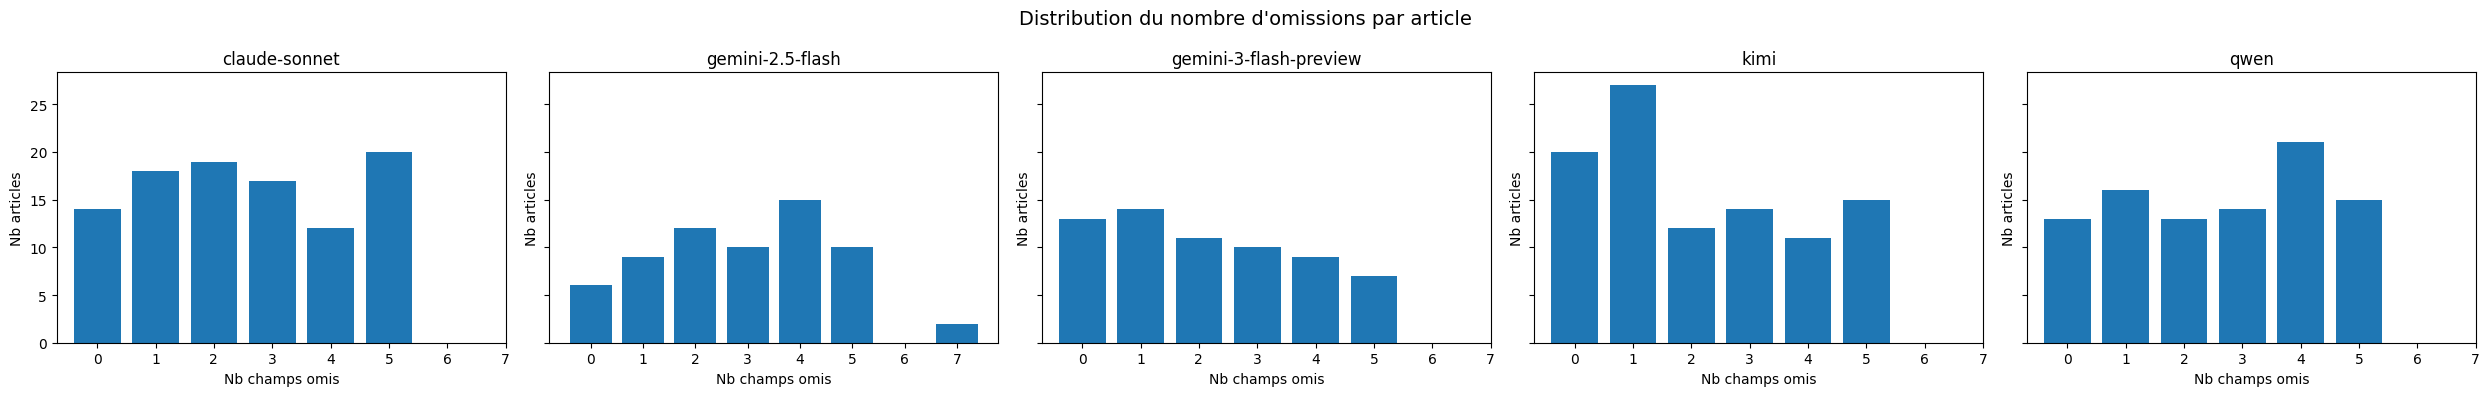

In [5]:
fig, axes = plt.subplots(1, len(data), figsize=(5*len(data), 4), sharey=True)
if len(data) == 1:
    axes = [axes]

for ax, (model_name, articles) in zip(axes, data.items()):
    omission_counts = []
    for article in articles:
        info = article.get("information", {})
        n = sum(1 for f in INFO_FIELDS if info.get(f, "Not specified") == "Not specified")
        omission_counts.append(n)

    counts = Counter(omission_counts)
    x = sorted(counts.keys())
    y = [counts[k] for k in x]
    ax.bar(x, y)
    ax.set_title(model_name)
    ax.set_xlabel("Nb champs omis")
    ax.set_ylabel("Nb articles")
    ax.set_xticks(range(0, 8))

plt.suptitle("Distribution du nombre d'omissions par article", fontsize=14)
plt.tight_layout()
plt.show()

## 4. XML Tags Compliance

In [6]:
def check_tags(text):
    found = {}
    for tag in EXPECTED_TAGS:
        pattern = f"<{tag}>.*?</{tag}>"
        found[tag] = bool(re.search(pattern, text, re.DOTALL))
    return found

tags_data = []

for model_name, articles in data.items():
    tag_counts = defaultdict(int)

    for article in articles:
        text = article.get("article", "")
        info = article.get("information", {})
        tags = check_tags(text)

        for tag in EXPECTED_TAGS:
            if tags[tag]:
                tag_counts[tag] += 1

    total = len(articles)
    row = {"Model": model_name}
    for tag in EXPECTED_TAGS:
        row[f"<{tag}>"] = f"{tag_counts[tag]}/{total}"
    tags_data.append(row)

pd.DataFrame(tags_data)

,Model,<model>,<params>,<gpu_count>,<hardware>,<training>,<country>,<year>
0,claude-sonnet,60/100,63/100,62/100,66/100,63/100,71/100,62/100
1,gemini-2.5-flash,41/64,42/64,40/64,41/64,36/64,34/64,40/64
2,gemini-3-flash-preview,48/64,44/64,42/64,45/64,45/64,43/64,44/64
3,kimi,78/99,56/99,71/99,69/99,69/99,67/99,69/99
4,qwen,71/92,55/92,65/92,63/92,63/92,62/92,56/92


## 5. Article Length

In [7]:
length_data = []

for model_name, articles in data.items():
    words = [len(a.get("article", "").split()) for a in articles]
    paras = [len([p for p in a.get("article", "").split('\n\n') if p.strip()]) for a in articles]

    length_data.append({
        "Model": model_name,
        "Words (min)": min(words),
        "Words (max)": max(words),
        "Words (avg)": f"{sum(words)/len(words):.0f}",
        "Paragraphs (avg)": f"{sum(paras)/len(paras):.1f}"
    })

pd.DataFrame(length_data)

,Model,Words (min),Words (max),Words (avg),Paragraphs (avg)
0,claude-sonnet,155,383,221,1.4
1,gemini-2.5-flash,172,375,293,3.1
2,gemini-3-flash-preview,131,336,230,2.4
3,kimi,96,248,159,1.0
4,qwen,1,185,135,1.0


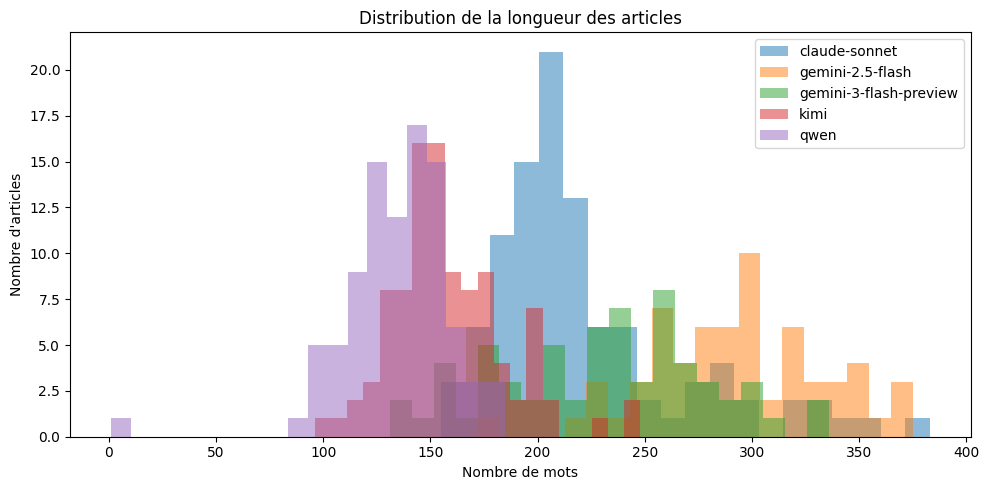

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))

for model_name, articles in data.items():
    words = [len(a.get("article", "").split()) for a in articles]
    ax.hist(words, bins=20, alpha=0.5, label=model_name)

ax.set_xlabel("Nombre de mots")
ax.set_ylabel("Nombre d'articles")
ax.set_title("Distribution de la longueur des articles")
ax.legend()
plt.tight_layout()
plt.show()

## 6. Diversity Analysis

### 6.1 Unique Model Names

In [9]:
def extract_tag_value(text, tag):
    match = re.search(f"<{tag}>(.*?)</{tag}>", text, re.DOTALL)
    return match.group(1).strip() if match else None

for model_name, articles in data.items():
    names = []
    for a in articles:
        info = a.get("information", {})
        name = info.get("model_name", "Not specified")
        if name != "Not specified":
            names.append(name)

    unique = set(names)
    print(f"\n{model_name}: {len(unique)} unique / {len(names)} specified")
    duplicates = {n: c for n, c in Counter(names).items() if c > 1}
    if duplicates:
        print(f"  Duplicates: {duplicates}")


claude-sonnet: 59 unique / 59 specified

gemini-2.5-flash: 39 unique / 39 specified

gemini-3-flash-preview: 48 unique / 48 specified

kimi: 69 unique / 76 specified
  Duplicates: {'OpenAI-TritonFlow-9B': 2, 'UKP-PubMedBERT-110M': 3, 'Google-VideoPoet-18B': 2, 'NeuralMuse-9B': 2, 'BridgeNet-11B': 2, 'Gemini-Nano-1.8B': 2}

qwen: 59 unique / 60 specified
  Duplicates: {'MediSpeech-Transformer': 2}


### 6.2 Hardware Diversity

In [10]:
for model_name, articles in data.items():
    hw_list = []
    for a in articles:
        info = a.get("information", {})
        hw = info.get("hardware", "Not specified")
        if hw != "Not specified":
            hw_list.append(hw)

    print(f"\n{model_name}: {len(set(hw_list))} unique / {len(hw_list)} specified")
    print(f"  Top 5: {Counter(hw_list).most_common(5)}")


claude-sonnet: 9 unique / 65 specified
  Top 5: [('NVIDIA H100 GPUs', 26), ('NVIDIA A100 40GB GPUs', 13), ('NVIDIA A100 80GB GPUs', 6), ('NVIDIA H100 SXM5 GPUs', 6), ('NVIDIA H100 SXM GPUs', 5)]

gemini-2.5-flash: 7 unique / 39 specified
  Top 5: [('NVIDIA A100 80GB GPUs', 20), ('NVIDIA H100 GPUs', 8), ('TPU v4 chips', 6), ('NVIDIA H100 80GB GPUs', 2), ('TPU v2 chips', 1)]

gemini-3-flash-preview: 9 unique / 45 specified
  Top 5: [('TPU v4 chips', 12), ('NVIDIA A100 80GB GPUs', 10), ('NVIDIA H100 GPUs', 8), ('NVIDIA H100 80GB GPUs', 7), ('NVIDIA A100 40GB GPUs', 3)]

kimi: 13 unique / 69 specified
  Top 5: [('NVIDIA H100 80GB GPUs', 21), ('NVIDIA A100 40GB GPUs', 11), ('TPU v5e chips', 9), ('NVIDIA A100 80GB GPUs', 9), ('TPU v5p chips', 5)]

qwen: 5 unique / 61 specified
  Top 5: [('NVIDIA A100 80GB GPUs', 28), ('NVIDIA H100 GPUs', 13), ('NVIDIA H100 80GB GPUs', 10), ('NVIDIA A100 GPUs', 8), ('NVIDIA V100 GPUs', 2)]


### 6.3 Country Diversity

In [11]:
for model_name, articles in data.items():
    countries = []
    for a in articles:
        info = a.get("information", {})
        c = info.get("country", "Not specified")
        if c != "Not specified":
            countries.append(c)

    print(f"\n{model_name}: {len(set(countries))} unique / {len(countries)} specified")
    print(f"  Top 5: {Counter(countries).most_common(5)}")


claude-sonnet: 6 unique / 71 specified
  Top 5: [('Singapore', 51), ('United States', 6), ('Canada', 5), ('Switzerland', 5), ('France', 2)]

gemini-2.5-flash: 8 unique / 32 specified
  Top 5: [('France', 9), ('United States', 8), ('Singapore', 5), ('Japan', 4), ('United Kingdom', 2)]

gemini-3-flash-preview: 8 unique / 43 specified
  Top 5: [('United States', 13), ('China', 9), ('Singapore', 8), ('United Kingdom', 5), ('France', 4)]

kimi: 11 unique / 69 specified
  Top 5: [('United States', 19), ('France', 16), ('Canada', 10), ('Singapore', 6), ('China', 6)]

qwen: 4 unique / 56 specified
  Top 5: [('United Kingdom', 30), ('United States', 13), ('Canada', 7), ('Germany', 6)]


### 6.4 Year Distribution

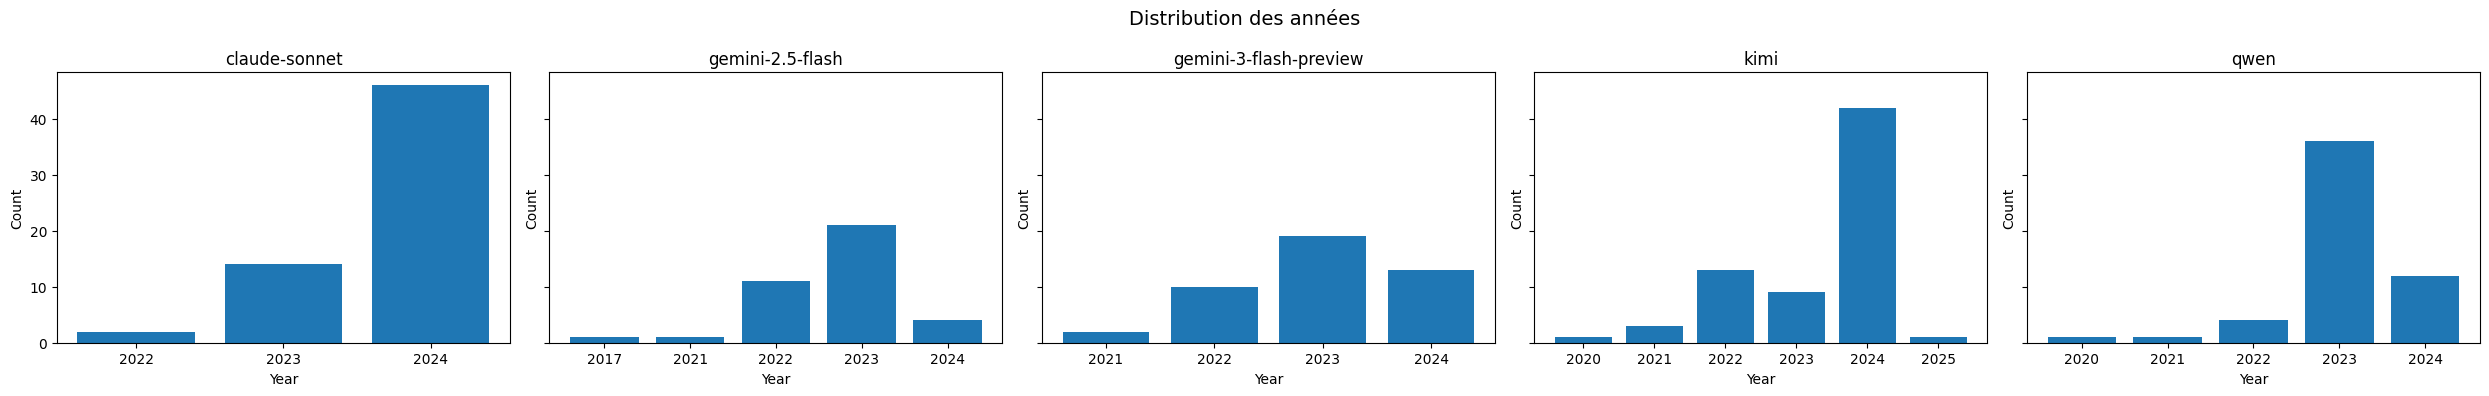

In [12]:
fig, axes = plt.subplots(1, len(data), figsize=(5*len(data), 4), sharey=True)
if len(data) == 1:
    axes = [axes]

for ax, (model_name, articles) in zip(axes, data.items()):
    years = []
    for a in articles:
        info = a.get("information", {})
        y = info.get("year", "Not specified")
        if y != "Not specified":
            years.append(str(y))

    counts = Counter(years)
    x = sorted(counts.keys())
    y = [counts[k] for k in x]
    ax.bar(x, y)
    ax.set_title(model_name)
    ax.set_xlabel("Year")
    ax.set_ylabel("Count")

plt.suptitle("Distribution des années", fontsize=14)
plt.tight_layout()
plt.show()

### 6.5 Bigram & Trigram de début par modèle

## 7. Summary Table

In [13]:
summary_data = []

for model_name, articles in data.items():
    total = len(articles)
    model_names = set()
    hardware = set()
    countries = set()
    years = set()
    omission_counts = []

    for article in articles:
        info = article.get("information", {})

        m = info.get("model_name", "Not specified")
        if m != "Not specified": model_names.add(m)

        h = info.get("hardware", "Not specified")
        if h != "Not specified": hardware.add(h)

        c = info.get("country", "Not specified")
        if c != "Not specified": countries.add(c)

        y = info.get("year", "Not specified")
        if y != "Not specified": years.add(str(y))

        n = sum(1 for f in INFO_FIELDS if info.get(f, "Not specified") == "Not specified")
        omission_counts.append(n)

    summary_data.append({
        "Model": model_name,
        "Articles": total,
        "Unique Models": len(model_names),
        "Unique Hardware": len(hardware),
        "Unique Countries": len(countries),
        "Unique Years": len(years),
        "Avg Omissions": f"{sum(omission_counts)/len(omission_counts):.1f}"
    })

pd.DataFrame(summary_data)

,Model,Articles,Unique Models,Unique Hardware,Unique Countries,Unique Years,Avg Omissions
0,claude-sonnet,100,59,9,6,3,2.5
1,gemini-2.5-flash,64,39,7,8,5,2.9
2,gemini-3-flash-preview,64,48,9,8,4,2.1
3,kimi,99,69,13,11,6,2.1
4,qwen,92,59,5,4,5,2.6


In [14]:
def clean_start(text):
    cleaned = re.sub(r'<[^>]+>', '', text).strip()
    return cleaned.split()

for model_name, articles in data.items():
    bigrams = []
    trigrams = []

    for a in articles:
        words = clean_start(a.get("article", ""))
        if len(words) >= 2:
            bigrams.append(" ".join(words[:2]))
        if len(words) >= 3:
            trigrams.append(" ".join(words[:3]))

    print(f"\n{'='*50}")
    print(f"{model_name}")
    print(f"{'='*50}")
    print(f"\n  Top 10 Bigrams ({len(set(bigrams))} unique / {len(bigrams)} total):")
    for bg, count in Counter(bigrams).most_common(10):
        print(f"    {count:3d}x  \"{bg}\"")

    print(f"\n  Top 10 Trigrams ({len(set(trigrams))} unique / {len(trigrams)} total):")
    for tg, count in Counter(trigrams).most_common(10):
        print(f"    {count:3d}x  \"{tg}\"")


claude-sonnet

  Top 10 Bigrams (26 unique / 100 total):
     16x  "The training"
     16x  "We developed"
     13x  "Our implementation"
      7x  "The model"
      6x  "We implemented"
      6x  "Our training"
      5x  "Our experimental"
      4x  "Our multimodal"
      3x  "We implement"
      3x  "We evaluate"

  Top 10 Trigrams (63 unique / 100 total):
     12x  "The training infrastructure"
      7x  "The model architecture"
      5x  "Our experimental setup"
      4x  "Our implementation leverages"
      4x  "Our implementation is"
      3x  "Our multimodal architecture,"
      3x  "Our training infrastructure"
      2x  "The experimental setup"
      2x  "We evaluate the"
      2x  "Our implementation of"

gemini-2.5-flash

  Top 10 Bigrams (25 unique / 64 total):
     28x  "The core"
      8x  "Our proposed"
      2x  "The foundational"
      2x  "Our multimodal"
      2x  "Our experimental"
      2x  "Our model,"
      2x  "The proposed"
      1x  "The SAM-Large"
      1x  